In [1]:
%matplotlib inline

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

syseng_throughputs_path = "../syseng_throughputs/"
sys.path.append(os.path.join(syseng_throughputs_path, "python"))

import bandpassUtils as bu
import sedUtils as su

plt.style.use(['ggplot'])
plt.rc("font", size=16)
plt.rc("axes", labelcolor="black")
plt.rc("lines", linewidth=2)
plt.rc("figure", figsize=(10, 6.5))

In [2]:
defaultDirs = bu.setDefaultDirs(rootDir = syseng_throughputs_path)

hardware = {}
system = {}
atmosphere = bu.readAtmosphere(defaultDirs['atmosphere'], atmosFile='atmos_10_aerosol.dat')
atmosphere12 = bu.readAtmosphere(defaultDirs['atmosphere'], atmosFile='pachonModtranAtm_12.dat')

# I copied atmos_15_aerosol.dat from the throughputs repo into syseng_throughputs/siteProperties
atmosphere15 = bu.readAtmosphere(defaultDirs['atmosphere'], atmosFile='atmos_15_aerosol.dat')
hardware['combo'], system['combo'] = bu.buildHardwareAndSystem(defaultDirs, atmosphereOverride=atmosphere)
genericDetector = defaultDirs['detector']

for det in (1, 2):
    defaultDirs['detector'] = 'vendor%d' % det
    hardware[det], system[det] = bu.buildHardwareAndSystem(defaultDirs, atmosphereOverride=atmosphere)

# Airmass 1.2
hardware12 = {}
system12 = {}
defaultDirs = bu.setDefaultDirs(rootDir = syseng_throughputs_path)
hardware12[1], system12[1] = bu.buildHardwareAndSystem(defaultDirs, atmosphereOverride=atmosphere)
hardware12[2], system12[2] = bu.buildHardwareAndSystem(defaultDirs, atmosphereOverride=atmosphere15)
    
# Versions of the throughputs that have perturbed filter bandpasses
hardware_filter = {}
system_filter = {}
for sys in (1, 2):
    defaultDirs = bu.setDefaultDirs(rootDir = syseng_throughputs_path)
    if sys == 2:
        defaultDirs['filters'] = "shifted_filters"
    hardware_filter[sys], system_filter[sys] = bu.buildHardwareAndSystem(defaultDirs, atmosphereOverride=atmosphere)

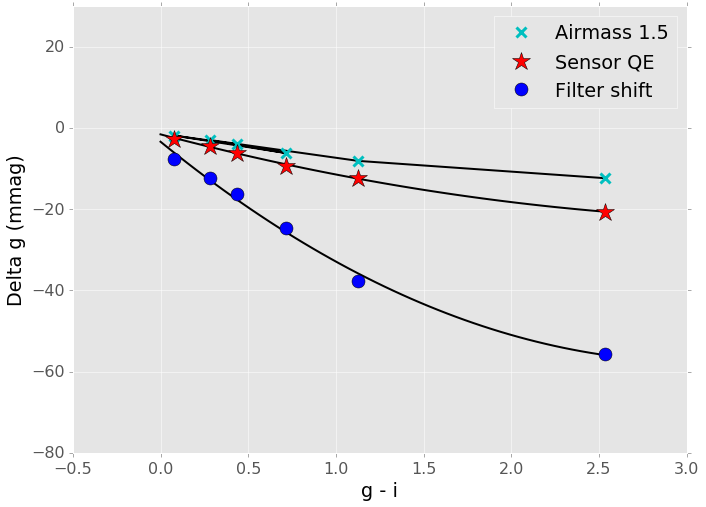

In [5]:
# Calculate color terms (magnitudes)
plt.figure(figsize=(11,8))

sedDir = os.path.join(syseng_throughputs_path, 'seds')
seds = su.readPhotSeds(sedDir = sedDir)
seds, system[det] = su.matchSedsBp(seds, system[det])

#
# Airmass 1.2
#
airmass_det1_mags =  su.calcNatMags(system12[1], seds)
airmass_det2_mags =  su.calcNatMags(system12[2], seds)
airmass_dmags = su.calcDeltaMags(airmass_det2_mags, airmass_det1_mags, mmags=True, matchBlue=False)


gi = su.calcGiColors(airmass_det1_mags)
#ug = su.calcAnyColor(det1_mags, 'g', 'i')

color = gi
plotFilter = 'g'


#airmass_gi = su.calcGiColors(det1_mags)
airmass_stellar_gi = []
airmass_stellar_delta_g = []
for objtype in ['stars']:
    for s in airmass_dmags[objtype]:
        airmass_stellar_gi.append(color[objtype][s])
        airmass_stellar_delta_g.append(airmass_dmags[objtype][s][plotFilter])
plt.plot(airmass_stellar_gi, airmass_stellar_delta_g, 'k-')        
plt.plot(airmass_stellar_gi, airmass_stellar_delta_g, 'cx', ms=10, mew=3, label="Airmass 1.5")


#
# Sensor QE
#
det1_mags =  su.calcNatMags(system[1], seds)
det2_mags =  su.calcNatMags(system[2], seds)
dmags = su.calcDeltaMags(det2_mags, det1_mags, mmags=True, matchBlue=False)

stellar_gi = []
stellar_delta_g = []
for objtype in ['stars']:
    for s in dmags[objtype]:
        stellar_gi.append(color[objtype][s])
        stellar_delta_g.append(dmags[objtype][s][plotFilter])

stellar_gi = np.array(stellar_gi)
stellar_delta_g = np.array(stellar_delta_g)
sel, = np.where(stellar_gi < 3.5)
fit = np.polyfit(stellar_gi[sel], stellar_delta_g[sel], 2)
x = np.linspace(0, 2.5)
plt.plot(x, np.polyval(fit, x), 'k-')


plt.plot(stellar_gi, stellar_delta_g, '*', ms=19, color='r',
         label="Sensor QE")



#
# Filter shift
#
filter1_mags =  su.calcNatMags(system_filter[1], seds)
filter2_mags =  su.calcNatMags(system_filter[2], seds)
filter_dmags = su.calcDeltaMags(filter2_mags, filter1_mags, mmags=True, matchBlue=False)

filter_gi = []
filter_delta_g = []
for objtype in ['stars']:
    for s in dmags[objtype]:
        filter_gi.append(color[objtype][s])
        filter_delta_g.append(filter_dmags[objtype][s][plotFilter])
filter_gi = np.array(filter_gi)
filter_delta_g = np.array(filter_delta_g)


filter_fit = np.polyfit(filter_gi[sel], filter_delta_g[sel], 2)
x = np.linspace(0, 2.5)
plt.plot(x, np.polyval(filter_fit, x), 'k-')
plt.plot(filter_gi, filter_delta_g, 'o', ms=13, color='b', label="Filter shift")

# This was easier to label for a linear fit
if False:
    plt.text(1.5, np.polyval(filter_fit, 1.5),
             '{:.2f}(g-i) + {:.2f}'.format(filter_fit[0], filter_fit[1]),
            verticalalignment="bottom")

plt.ylim(-80, 30)
plt.xlim(-0.5, 3)
plt.legend(loc=0, numpoints=1)
plt.xlabel("g - i")
plt.ylabel("Delta g (mmag)")
plt.savefig("figures/delta_g_vs_color.pdf")

In [ ]:
# Histogram of g-i colors of objects brighter than 20th in SDSS Stripe82
# This comes from stripe82_color_histogram.ipynb
#
gi_bin_centers =  array([-0.94897959, -0.84693878, -0.74489796, -0.64285714, -0.54081633,
       -0.43877551, -0.33673469, -0.23469388, -0.13265306, -0.03061224,
        0.07142857,  0.17346939,  0.2755102 ,  0.37755102,  0.47959184,
        0.58163265,  0.68367347,  0.78571429,  0.8877551 ,  0.98979592,
        1.09183673,  1.19387755,  1.29591837,  1.39795918,  1.5       ,
        1.60204082,  1.70408163,  1.80612245,  1.90816327,  2.01020408,
        2.1122449 ,  2.21428571,  2.31632653,  2.41836735,  2.52040816,
        2.62244898,  2.7244898 ,  2.82653061,  2.92857143,  3.03061224,
        3.13265306,  3.23469388,  3.33673469,  3.43877551,  3.54081633,
        3.64285714,  3.74489796,  3.84693878,  3.94897959])
gi_bin_values =  array([  1.00000000e+00,   8.00000000e+00,   6.00000000e+00,
         7.00000000e+00,   9.00000000e+00,   9.00000000e+00,
         1.30000000e+01,   1.50000000e+01,   3.20000000e+01,
         6.70000000e+01,   6.10000000e+01,   7.80000000e+01,
         1.56000000e+02,   5.74000000e+02,   2.04200000e+03,
         4.42100000e+03,   5.23100000e+03,   4.20300000e+03,
         3.38200000e+03,   2.73400000e+03,   2.07900000e+03,
         1.78500000e+03,   1.60900000e+03,   1.32100000e+03,
         1.07200000e+03,   9.40000000e+02,   8.90000000e+02,
         8.91000000e+02,   7.97000000e+02,   7.14000000e+02,
         7.38000000e+02,   7.25000000e+02,   5.71000000e+02,
         6.26000000e+02,   4.39000000e+02,   3.97000000e+02,
         2.59000000e+02,   1.52000000e+02,   1.06000000e+02,
         5.20000000e+01,   2.30000000e+01,   1.00000000e+01,
         0.00000000e+00,   4.00000000e+00,   2.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00])

plt.plot(gi_bin_centers, gi_bin_values, '-')
plt.xlabel("g-i magnitude")
plt.ylabel("N stars")
plt.title("Color distribution of stars $g < 20$")


In [ ]:
delta_shift = polyval(fit, gi_bin_centers)
mean_shift = np.average(delta_shift, weights=gi_bin_values)
plt.plot(delta_shift - mean_shift, gi_bin_values, '-', label="Sensor QE")

print("Sensor QE difference:")
for shift_value in (7,10,15):
    sel_gt_shift, = np.where(np.abs(delta_shift - mean_shift) > shift_value)
    frac_gt_shift = np.sum(gi_bin_values[sel_gt_shift])/float(np.sum(gi_bin_values))
    print("{:.2f}% beyond +/- {:.0f} mmag".format(frac_gt_shift*100, shift_value))
    
print("="*10)
print("")
print("Filter variation:")
delta_filter_shift = polyval(filter_fit, gi_bin_centers)
mean_filter_shift = np.average(delta_filter_shift, weights=gi_bin_values)
plt.plot(delta_filter_shift - mean_filter_shift, gi_bin_values, '-', label="Filter Shift")
for shift_value in (7,10,15,20):
    sel_gt_shift, = np.where(np.abs(delta_filter_shift - mean_filter_shift) > shift_value)
    frac_gt_shift = np.sum(gi_bin_values[sel_gt_shift])/float(np.sum(gi_bin_values))
    print("{:.2f}% beyond +/- {:.0f} mmag".format(frac_gt_shift*100, shift_value))
    
plt.xlim(-45,45)
plt.xlabel(("Delta g magnitude (mmag)"))
plt.ylabel("N stars")
plt.legend(loc=0)
plt.savefig("figures/delta_g_histogram.pdf")

In [ ]:
increasing_shift_order = np.argsort(np.abs(delta_shift - mean_shift))
decreasing_shift_order = increasing_shift_order[::-1]
plt.plot(np.abs(delta_shift[decreasing_shift_order] - mean_shift),
         np.cumsum(gi_bin_values[decreasing_shift_order])/np.sum(gi_bin_values), label="Sensor QE")


increasing_shift_order = np.argsort(np.abs(delta_filter_shift - mean_filter_shift))
decreasing_shift_order = increasing_shift_order[::-1]

plt.plot(np.abs(delta_filter_shift[decreasing_shift_order] - mean_filter_shift),
         np.cumsum(gi_bin_values[decreasing_shift_order])/np.sum(gi_bin_values), label="Filter shift")


plt.xlim(0, 30)
plt.xlabel("$|\Delta g|$ (mmag)")
plt.ylabel("Fraction with $>\Delta g$ shift")
plt.legend(loc=0)
plt.savefig("figures/delta_g_cumulative.pdf")

In [ ]:
# Show what these look like (print m5 limits on throughput curves)
plt.figure()

filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
filterlist = ( 'g')
filtercolors = {'u':'b', 'g':'c', 'r':'g',
                'i':'y', 'z':'r', 'y':'m'}

for f in filterlist:
    for det in [1, 2]:
        if det == 1:
            linestyle = ':'
            spacer= ' '
        else:
            linestyle = '-'
            spacer = ''
        plt.plot(system[det][f].wavelen, system[det][f].sb, linestyle=linestyle, color=filtercolors[f],
                label='%s %s:%s' %(det, f, spacer))
#plt.legend(loc=(0.85, 0.5), fancybox=True, numpoints=1, fontsize='small')
plt.ylim(0, 0.6)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Fractional Throughput Response')
plt.title('System total response curves')

In [ ]:

plt.subplot(2,1,1)
for det in [1, 2]:
    for f in filterlist:
        if det == 1:
            linestyle = ':'
        else:
            linestyle = '-'
        plt.plot(system[det][f].wavelen, system[det][f].phi, linestyle=linestyle,
                 color=filtercolors[f],
                 label='%s %s' %(det, f))
        
    
    
plt.xlim(350, 600)
plt.ylim(ymin=0, ymax=0.01)
#plt.title('Normalized system response curves ($\phi$)')
plt.ylabel('$\phi$')

plt.subplot(2,1,2)

for f in filterlist:
    plt.plot(system[1][f].wavelen, system[1][f].phi - system[2][f].phi,
            color=filtercolors[f])


#plt.legend(loc='upper right', fancybox=True, numpoints=1, fontsize='small')
plt.xlabel('Wavelength (nm)')
plt.ylabel('$\phi_1 - \phi_2$')
#plt.axhline(1.0, color='k')
plt.xlim(350, 600)
plt.subplots_adjust(left=0.15)
plt.savefig("figures/QE_response_curves.pdf")

In [ ]:
plt.subplot(2,1,1)
for det in [1, 2]:
    for f in filterlist:
        if det == 1:
            linestyle = ':'
        else:
            linestyle = '-'
        plt.plot(system_filter[det][f].wavelen, system_filter[det][f].phi, linestyle=linestyle,
                 color=filtercolors[f],
                 label='%s %s' %(det, f))
plt.xlim(350, 600)
plt.ylim(ymin=0, ymax=0.01)
#plt.title('Normalized system response curves ($\phi$)')
plt.ylabel('$\phi$')

plt.subplot(2,1,2)


for f in filterlist:
    plt.plot(system_filter[1][f].wavelen, system_filter[1][f].phi - system_filter[2][f].phi,
            color=filtercolors[f])
#plt.ylim(0.5, 1.6)
plt.xlim(350, 600)
plt.xlabel('Wavelength (nm)')
plt.ylabel('$\phi_1 - \phi_2$')
plt.subplots_adjust(left=0.15)
plt.savefig("figures/filter_response_curves.pdf")
